In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, min as spark_min, max as spark_max, avg, mean, stddev, udf, when
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Row
import matplotlib.pyplot as plt
import seaborn as sns
import math


In [ ]:
spark = SparkSession.builder.appName("Big Data Classification").getOrCreate()
spark

In [ ]:
df = spark.read.csv('BankCustomerData.csv', header=True, inferSchema=True)
df.show()

+---+---+------------+-------+---------+-------+-------+-------+----+---+-----+--------+--------+-----+--------+------------+
| ID|age|         job|marital|education|default|balance|housing|loan|day|month|duration|campaign|pdays|previous|term_deposit|
+---+---+------------+-------+---------+-------+-------+-------+----+---+-----+--------+--------+-----+--------+------------+
|  1| 58|  management|      2| tertiary|      0|   2143|      1|   0|  5|  may|     261|       1|   -1|       0|           0|
|  2| 44|  technician|      1|secondary|      0|     29|      1|   0|  5|  may|     151|       1|   -1|       0|           0|
|  3| 33|entrepreneur|      2|secondary|      0|      2|      1|   1|  5|  may|      76|       1|   -1|       0|           0|
|  4| 47| blue-collar|      2|  unknown|      0|   1506|      1|   0|  5|  may|      92|       1|   -1|       0|           0|
|  5| 33|     unknown|      1|  unknown|      0|      1|      0|   0|  5|  may|     198|       1|   -1|       0|      

In [ ]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- term_deposit: integer (nullable = true)



# 1. Mô tả dữ liệu

## Giá trị cao nhất, thấp nhất của các thuộc tính numberic

In [ ]:
max_min_values = df.select(
    spark_max("age").alias("max_age"), spark_min("age").alias("min_age"),
    spark_max("balance").alias("max_balance"), spark_min("balance").alias("min_balance"),
    spark_max("duration").alias("max_duration"), spark_min("duration").alias("min_duration"),
    spark_max("campaign").alias("max_campaign"), spark_min("campaign").alias("min_campaign"),
    spark_max("pdays").alias("max_pdays"), spark_min("pdays").alias("min_pdays"),
    spark_max("previous").alias("max_previous"), spark_min("previous").alias("min_previous")
).first()

rows = [
    Row(statistic="max_age", value=max_min_values['max_age']),
    Row(statistic="min_age", value=max_min_values['min_age']),
    Row(statistic="max_balance", value=max_min_values['max_balance']),
    Row(statistic="min_balance", value=max_min_values['min_balance']),
    Row(statistic="max_duration", value=max_min_values['max_duration']),
    Row(statistic="min_duration", value=max_min_values['min_duration']),
    Row(statistic="max_campaign", value=max_min_values['max_campaign']),
    Row(statistic="min_campaign", value=max_min_values['min_campaign']),
    Row(statistic="max_pdays", value=max_min_values['max_pdays']),
    Row(statistic="min_pdays", value=max_min_values['min_pdays']),
    Row(statistic="max_previous", value=max_min_values['max_previous']),
    Row(statistic="min_previous", value=max_min_values['min_previous'])
]

stats_df = spark.createDataFrame(rows)
stats_df.show()

+------------+------+
|   statistic| value|
+------------+------+
|     max_age|    95|
|     min_age|    18|
| max_balance|102127|
| min_balance| -8019|
|max_duration|  4918|
|min_duration|     0|
|max_campaign|    63|
|min_campaign|     1|
|   max_pdays|   536|
|   min_pdays|    -1|
|max_previous|   275|
|min_previous|     0|
+------------+------+



## Giá trị phổ biến nhất, hiếm nhất của các thuộc tính

In [ ]:
def get_most_and_least_common(df, col_name):
    counts = df.groupBy(col_name).count().orderBy("count", ascending=False)
    most_common = counts.first()
    least_common = counts.orderBy("count", ascending=True).first()
    return most_common, least_common


attributes = ['age','job', 'marital', 'education', 'default', 'housing', 'loan', 'day','month', 'term_deposit']
rows = []

for attr in attributes:
    most_common, least_common = get_most_and_least_common(df, attr)

    rows.append(Row(statistic=f"most_common_{attr}", value=most_common[attr], count=most_common['count']))
    rows.append(Row(statistic=f"least_common_{attr}", value=least_common[attr], count=least_common['count']))

stats_df = spark.createDataFrame(rows)
stats_df.show(truncate=False)

+-------------------------+-----------+-----+
|statistic                |value      |count|
+-------------------------+-----------+-----+
|most_common_age          |32         |1999 |
|least_common_age         |94         |1    |
|most_common_job          |blue-collar|9536 |
|least_common_job         |unknown    |264  |
|most_common_marital      |2          |25868|
|least_common_marital     |0          |4965 |
|most_common_education    |secondary  |22066|
|least_common_education   |unknown    |1690 |
|most_common_default      |0          |41828|
|least_common_default     |1          |811  |
|most_common_housing      |1          |24590|
|least_common_housing     |0          |18049|
|most_common_loan         |0          |35554|
|least_common_loan        |1          |7085 |
|most_common_day          |20         |2703 |
|least_common_day         |1          |235  |
|most_common_month        |may        |13532|
|least_common_month       |dec        |214  |
|most_common_term_deposit |0      

## Giá trị trung bình, trung vị của các thuộc tính numberic

In [ ]:
numeric_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

avg_values = df.select(
    [avg(col).alias(f"avg_{col}") for col in numeric_columns]
).collect()[0]

median_values = df.approxQuantile(numeric_columns, [0.5], 0.01)
median_values_dict = {f"median_{col}": median for col, median in zip(numeric_columns, median_values)}


rows = []
for col in numeric_columns:
    rows.append(Row(statistic=f"avg_{col}", value=avg_values[f"avg_{col}"]))
    rows.append(Row(statistic=f"median_{col}", value=median_values_dict[f"median_{col}"][0]))


stats_df = spark.createDataFrame(rows)
stats_df.show(truncate=False)

+---------------+-------------------+
|statistic      |value              |
+---------------+-------------------+
|avg_age        |40.78880836792608  |
|median_age     |39.0               |
|avg_balance    |1331.863950843125  |
|median_balance |417.0              |
|avg_duration   |255.95750369380144 |
|median_duration|175.0              |
|avg_campaign   |2.8164122047890428 |
|median_campaign|2.0                |
|avg_pdays      |34.16914092732006  |
|median_pdays   |-1.0               |
|avg_previous   |0.46544243532915874|
|median_previous|0.0                |
+---------------+-------------------+



# 2. Tiền xử lý dữ liệu

### Loại bỏ thuộc tính không cần thiêt

In [ ]:
df = df.drop('ID')
print(len(df.columns))

15


### Nhận diện dữ liệu bị nhiễu

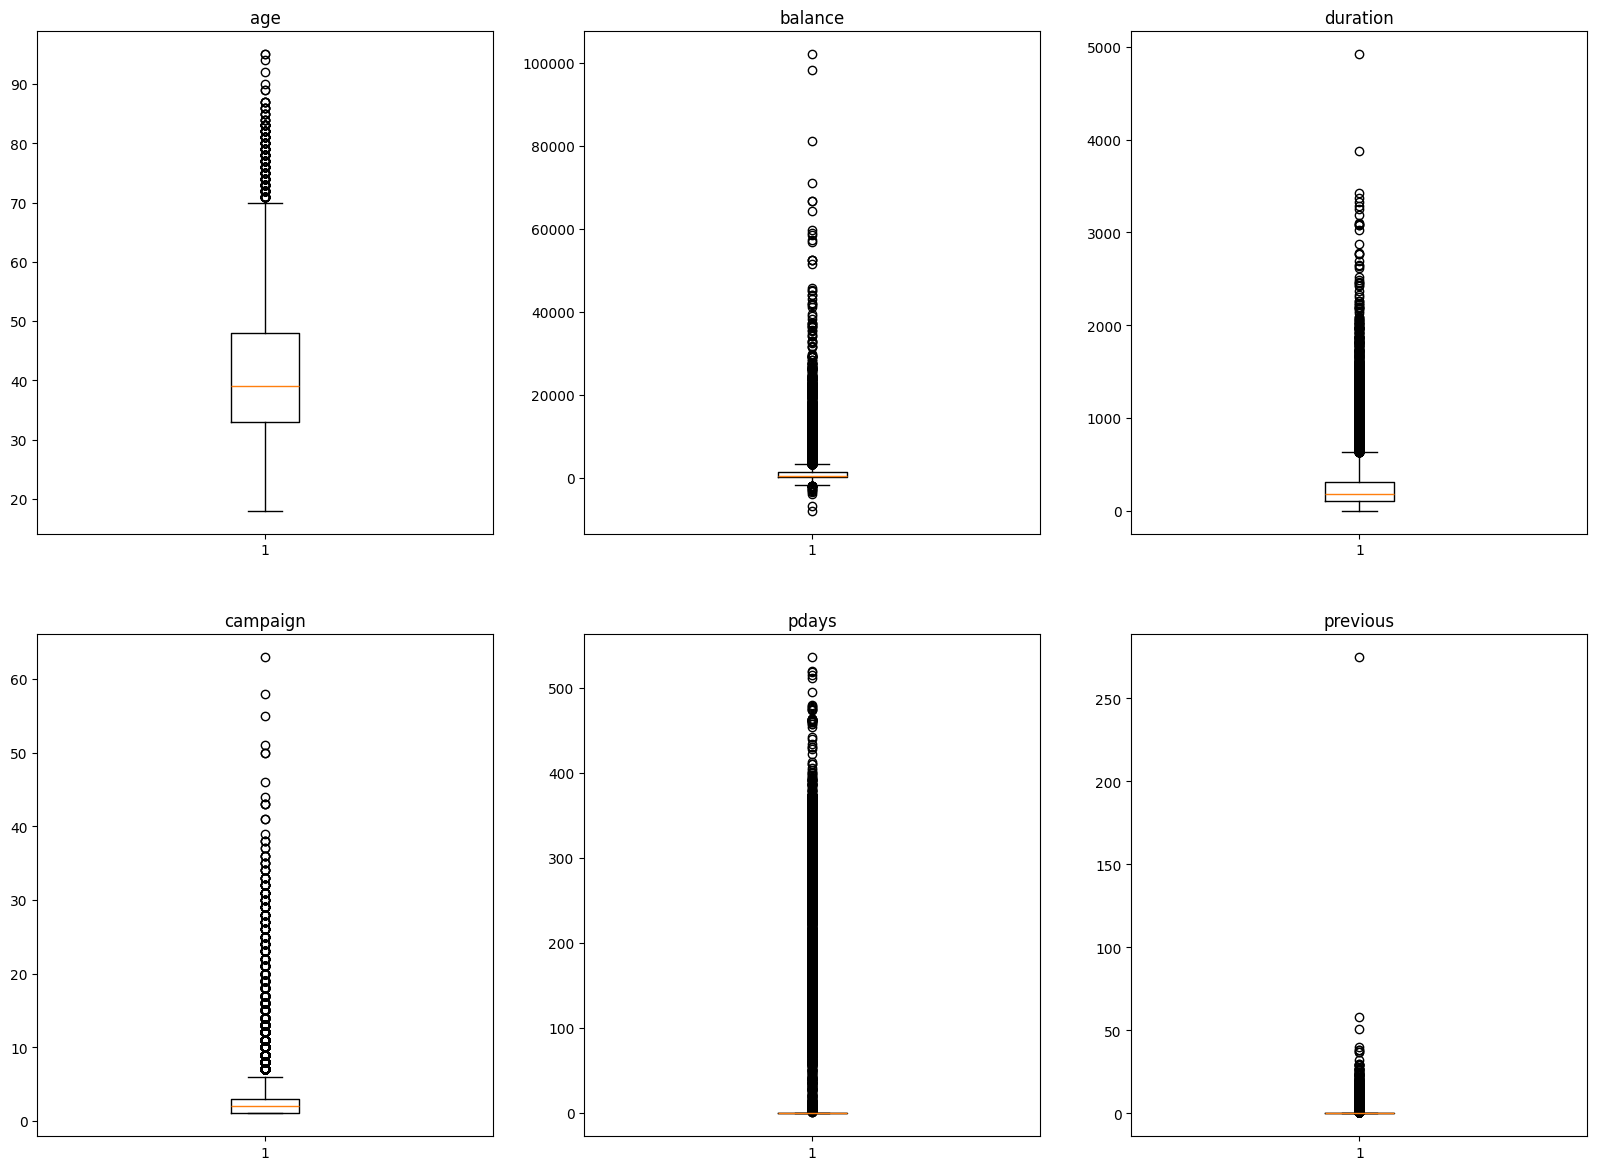

In [ ]:
numberic_col = ['age',
                'balance',
                'duration',
                'campaign',
                'pdays',
                'previous',
]
plt.figure(figsize=(20,30))

for i, col in enumerate(numberic_col):
    plt.subplot(4,3,i+1)
    data = df.select(col).toPandas()
    plt.boxplot(data, whis=1.5)
    plt.title(col)


In [ ]:
# Xác định số lượng và phân trăm các giá trị ngoại lệ
# Box plot
def outlier_statistic(df, numberic_col):
    for col in numberic_col:
        quartiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
        q1 = quartiles[0]
        q3 = quartiles[1]
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        count_outliers = df.filter((df[col] < lower_bound) | (df[col] > upper_bound)).count()
        percent_outliers = count_outliers / df.count() * 100

        print(f"Cột {col} có {count_outliers} giá trị ngoại lệ, chiếm {percent_outliers:.2f}%")


outlier_statistic(df, numberic_col)

Cột age có 367 giá trị ngoại lệ, chiếm 0.86%
Cột balance có 5620 giá trị ngoại lệ, chiếm 13.18%
Cột duration có 4077 giá trị ngoại lệ, chiếm 9.56%
Cột campaign có 3021 giá trị ngoại lệ, chiếm 7.09%
Cột pdays có 6557 giá trị ngoại lệ, chiếm 15.38%
Cột previous có 6557 giá trị ngoại lệ, chiếm 15.38%


In [ ]:
def QuantileOutlierClipper(df, col):
    quartiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
    q1 = quartiles[0]
    q3 = quartiles[1]
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df = df.withColumn(col, df[col].cast(DoubleType()))
    clip_udf = udf(lambda x: min(upper_bound, max(lower_bound, x)), DoubleType())

    return df.withColumn(col, clip_udf(df[col]))


In [ ]:
for col in numberic_col:
    df = QuantileOutlierClipper(df, col)

outlier_statistic(df, numberic_col)

Cột age có 0 giá trị ngoại lệ, chiếm 0.00%
Cột balance có 0 giá trị ngoại lệ, chiếm 0.00%
Cột duration có 0 giá trị ngoại lệ, chiếm 0.00%
Cột campaign có 0 giá trị ngoại lệ, chiếm 0.00%
Cột pdays có 0 giá trị ngoại lệ, chiếm 0.00%
Cột previous có 0 giá trị ngoại lệ, chiếm 0.00%


### Nhận diện dữ liệu bị thiếu

In [ ]:
def count_missing_values(df):
    missing_counts = []
    total_rows = df.count()
    for col in df.columns:
        missing_count = df.where(df[col].isNull()).count()
        missing_counts.append((col, missing_count, missing_count/total_rows * 100))
    return missing_counts

missing_counts = count_missing_values(df)
for col, missing_count, missing_percent in missing_counts:
    print(f"Cột {col} có {missing_count} giá trị bị thiếu, chiếm {missing_percent:.2f}%")

Cột age có 0 giá trị bị thiếu, chiếm 0.00%
Cột job có 0 giá trị bị thiếu, chiếm 0.00%
Cột marital có 0 giá trị bị thiếu, chiếm 0.00%
Cột education có 0 giá trị bị thiếu, chiếm 0.00%
Cột default có 0 giá trị bị thiếu, chiếm 0.00%
Cột balance có 0 giá trị bị thiếu, chiếm 0.00%
Cột housing có 0 giá trị bị thiếu, chiếm 0.00%
Cột loan có 0 giá trị bị thiếu, chiếm 0.00%
Cột day có 0 giá trị bị thiếu, chiếm 0.00%
Cột month có 0 giá trị bị thiếu, chiếm 0.00%
Cột duration có 0 giá trị bị thiếu, chiếm 0.00%
Cột campaign có 0 giá trị bị thiếu, chiếm 0.00%
Cột pdays có 0 giá trị bị thiếu, chiếm 0.00%
Cột previous có 0 giá trị bị thiếu, chiếm 0.00%
Cột term_deposit có 0 giá trị bị thiếu, chiếm 0.00%


### Xử lý ý nghĩa của dữ liệu

In [ ]:
from pyspark.ml.feature import StringIndexer

## Dữ liệu dạng danh mục - job, education
def label_encoder(df, col_name):
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name+"_indexed")
    indexed_df = indexer.fit(df).transform(df)

    return indexed_df

df = label_encoder(df,'job')
df = label_encoder(df,'education')
df = df.drop('job')
df = df.drop('education')

In [ ]:
df.groupBy('month').count().show()

+-----+-----+
|month|count|
+-----+-----+
|  jun| 5128|
|  aug| 5987|
|  may|13532|
|  feb| 2296|
|  sep|  282|
|  mar|  258|
|  oct|  518|
|  jul| 6587|
|  nov| 3895|
|  apr| 2718|
|  dec|  214|
|  jan| 1224|
+-----+-----+



In [ ]:
## Dữ liệu dạng danh mục có thứ bậc - month
months_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

for month_str, month_num in months_mapping.items():
    df = df.withColumn("month", when(df["month"] == month_str, month_num).otherwise(df["month"]))

df = df.withColumn('month', df['month'].cast(IntegerType()))

### Chuẩn hóa dữ liệu

In [ ]:
selected_cols = ['balance', 'duration']

summary_df = df.select(selected_cols).describe()
summary_df.show()

+-------+------------------+------------------+
|summary|           balance|          duration|
+-------+------------------+------------------+
|  count|             42639|             42639|
|   mean| 834.8974178568916|225.53082858416005|
| stddev|1012.4357491438211|161.42443594668387|
|    min|           -1560.0|               0.0|
|    max|            2800.0|             559.0|
+-------+------------------+------------------+



In [ ]:
def normalize_dataframe(df, columns):
    min_max_values = {}
    for column in columns:
        min_value = df.select(spark_min(col(column))).collect()[0][0]
        max_value = df.select(spark_max(col(column))).collect()[0][0]
        min_max_values[column] = (min_value, max_value)

    normalized_data = df
    for column, (min_value, max_value) in min_max_values.items():
        new_column_name = f"{column}_normalized"
        normalized_data = normalized_data.withColumn(
            new_column_name, (col(column) - min_value) / (max_value - min_value)
        ).drop(column)

    return normalized_data

columns = ['balance', 'duration']
normalize_df = normalize_dataframe(df, columns)

In [ ]:
normalize_df = normalize_df.drop('balance')
normalize_df = normalize_df.drop('duration')

In [ ]:
selected_cols = ['balance_normalized', 'duration_normalized']

summary_df = normalize_df.select(selected_cols).describe()
summary_df.show()

+-------+------------------+-------------------+
|summary|balance_normalized|duration_normalized|
+-------+------------------+-------------------+
|  count|             42639|              42639|
|   mean|0.5492883985910085|0.40345407617917645|
| stddev|0.2322100342072999|0.28877358845560713|
|    min|               0.0|                0.0|
|    max|               1.0|                1.0|
+-------+------------------+-------------------+



In [ ]:
# Chuyển thuộc tính term_deposit về cuối
selected_cols = [col for col in normalize_df.columns if col != 'term_deposit']
term_deposit_col = col('term_deposit')

new_df = normalize_df.select(selected_cols + [term_deposit_col])
new_df.show()

+----+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+-------------------+-------------------+------------+
| age|marital|default|housing|loan|day|month|campaign|pdays|previous|job_indexed|education_indexed| balance_normalized|duration_normalized|term_deposit|
+----+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+-------------------+-------------------+------------+
|58.0|      2|      0|      1|   0|  5|    5|     1.0| -1.0|     0.0|        1.0|              1.0| 0.8493119266055046| 0.4669051878354204|           0|
|44.0|      1|      0|      1|   0|  5|    5|     1.0| -1.0|     0.0|        2.0|              0.0|0.36444954128440366| 0.2701252236135957|           0|
|33.0|      2|      0|      1|   1|  5|    5|     1.0| -1.0|     0.0|        7.0|              0.0|0.35825688073394496|0.13595706618962433|           0|
|47.0|      2|      0|      1|   0|  5|    5|     1.0| -1.0|     0.0|        0.0| 

In [ ]:
new_df.toPandas().to_csv('BankCustomerData_Processed.csv', index=0)

### Tách dữ liệu Train & Test

In [ ]:
df = spark.read.csv('BankCustomerData_Processed.csv', header=True, inferSchema=True)
df.show()

+---+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+------------------+-------------------+------------+
|age|marital|default|housing|loan|day|month|campaign|pdays|previous|job_indexed|education_indexed|balance_normalized|duration_normalized|term_deposit|
+---+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+------------------+-------------------+------------+
| 58|      2|      0|      1|   0|  5|    5|       1|   -1|       0|          1|                1|       0.849311927|        0.466905188|           0|
| 44|      1|      0|      1|   0|  5|    5|       1|   -1|       0|          2|                0|       0.364449541|        0.270125224|           0|
| 33|      2|      0|      1|   1|  5|    5|       1|   -1|       0|          7|                0|       0.358256881|        0.135957066|           0|
| 47|      2|      0|      1|   0|  5|    5|       1|   -1|       0|          0|              

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

X_train = train_data.drop('term_deposit')
y_train = train_data.select('term_deposit')

X_test = test_data.drop('term_deposit')
y_test = test_data.select('term_deposit')

In [ ]:
print(f"X_train: {X_train.count()} rows, {len(X_train.columns)} columns")
print(f"y_train: {y_train.count()} rows, {len(y_train.columns)} columns")
print(f"X_test: {X_test.count()} rows, {len(X_test.columns)} columns")
print(f"y_test: {y_test.count()} rows, {len(y_test.columns)} columns")

X_train: 34111 rows, 14 columns
y_train: 34111 rows, 1 columns
X_test: 8528 rows, 14 columns
y_test: 8528 rows, 1 columns
